In [50]:
# exploratory analysis

# we want to see if there is a correlation between the music and the EEG data
# baseline 10mins recording with no music & noise cancelling earphones
# 10mins playing the song: Rolling 7s by Dirty Honey...
# (worthnoting, the song is 3:30mins long, so it's played 3 times in a 
# row but we lost some samples due to network issues)
import pandas as pd


In [110]:
import os
import json
import re
def rnOccur(arr,v,n):
    for x in range(len(arr)-1,0,-1):
        if arr[x] == v:
            if n == 0: return x
            n-=1
    return -1

class extractBundledEEG:
    def __init__(self,fold):
        self.categories = dict()
        self.tagIdMap = dict()
        files = next(os.walk(fold))
        for f in files[2]:
            if f[-5:] == ".json":
                id = f[f.rindex("_")+1:-5]

                if id not in self.tagIdMap: self.tagIdMap[id] = dict()
                
                type = f[rnOccur(f,"_",1)+1:f.rindex("_")]
                # print(type,id,f)

                self.tagIdMap[id][type] = os.path.join(files[0],f)

                if type == "event":
                    with open(os.path.join(files[0],f),"r") as of:
                        tagInfo = json.load(of)["event"]["description"]
                        if tagInfo not in self.categories: self.categories[tagInfo] = list()
                        self.categories[tagInfo].append(id)

    def prune(self):
        rmId = list()
        for x in self.tagIdMap:
            for y in self.tagIdMap[x]:

        

    def extractById(self, id):
        return self.tagIdMap[str(id)]
    
    def extractByTags(self, tag):
        ret = dict()
        for x in self.categories[str(tag)]:
            ret[x] = self.tagIdMap[x]
        return ret

    def mergeTagsWithRegex(self,reg,newTag):
        newCategory = list()
        oldTags = list()
        for tag in self.categories:
            if re.search(reg,tag):
                newCategory+= list(self.categories[tag])
                oldTags.append(tag)
        for tag in oldTags: del self.categories[tag]

        self.categories[newTag] = newCategory

    def mergeCategories(self,categories,newTag):
        newCategory = list()
        oldTags = list()
        for tag in categories:
                newCategory+= list(self.categories[tag])
                oldTags.append(tag)
        for tag in oldTags: del self.categories[tag]

        self.categories[newTag] = newCategory


files = extractBundledEEG("./music_data/")
files.prune()
print(files.categories)
files.mergeTagsWithRegex("[cC]lose","Eyes Closed")
files.mergeCategories(["Working","Eyes Open"],"Eyes Open")
files.extractByTags("Eyes Open")

{'Eyes Closed': ['1685033286', '1685033139'], 'Eyes Open': ['1685033809', '1684961614'], 'Working': ['1684961211'], '': ['1684960760']}


{'1684961211': {'focus': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_focus_1684961211.json',
  'calm': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_calm_1684961211.json',
  'signalQuality': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_signalQuality_1684961211.json',
  'event': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_fusion_event_1684961211.json',
  'rawBrainwaves': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_rawBrainwaves_1684961211.json',
  'powerByBand': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_powerByBand_1684961211.json'},
 '1685033809': {'event': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_fusion_event_1685033809.json'},
 '1684961614': {'powerByBand': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_powerByBand_1684961614.json',
  'rawBrainwaves': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_rawBrainwaves_1684961614.json',
  'event': './music_data/05c

In [68]:
# generate summary of the signalQuality across channels
def get_signal_quality_summary(signalQuality):
    channel_good_percentage = {}

    for col in signalQuality:
        if col in ['CP3_status', 'C3_status', 'F5_status', 'PO3_status', 'PO4_status', 'F6_status', 'C4_status', 'CP4_status']:
            channel_states = signalQuality[col].value_counts()
            
            no_of_okay_samples = 0

            if 'good' in channel_states:
                no_of_okay_samples += channel_states['good']
            if 'great' in channel_states:
                no_of_okay_samples += channel_states['great']

            percentage_good = no_of_okay_samples / len(signalQuality[col])

            col_name_split = col.split('_')

            channel_good_percentage[col_name_split[0]] = percentage_good

    # this helps us know what channels to discard in our analysis
    return channel_good_percentage

In [53]:
def get_rolling_powerByBand(powerByBand, signalQuality, window_size=5):
    # we want to split the recording for a session in to 5sec chunks average
    # see if there's any difference in the average. 

    # we will discard any channels that have less than 70% good samples
    channel_good_percentage = get_signal_quality_summary(signalQuality)

    # we will discard any channels that have less than 70% good samples
    for entry in channel_good_percentage:
        if channel_good_percentage[entry] < 0.7:
            del powerByBand[entry + '_alpha']
            del powerByBand[entry + '_beta']
            del powerByBand[entry + '_delta']
            del powerByBand[entry + '_gamma']
            del powerByBand[entry + '_theta']

    # we will split the recording in to 5sec chunks
    powerByBand_rolling = powerByBand.median() #.rolling(window=window_size).mean()

    # we will discard the first 5sec of the recording
    # powerByBand_rolling = powerByBand_rolling[window_size:]

    return powerByBand_rolling


In [104]:
# load the data
powerByBand_eyesclosed = pd.read_json('/Users/oreogundipe/lab/fusion/analysis/music_data/eyes_closed/2db533ce-8349-427f-9cdd-a4a7f6b62266_neurosity_powerByBand_1682192967.json')
signalQuality_eyesclosed = pd.read_json('/Users/oreogundipe/lab/fusion/analysis/music_data/eyes_closed/2db533ce-8349-427f-9cdd-a4a7f6b62266_neurosity_signalQuality_1682192967.json')

powerByBand_rolling_eyesclosed = get_rolling_powerByBand(powerByBand_eyesclosed, signalQuality_eyesclosed)
powerByBand_rolling_eyesclosed

unixTimestamp    1.685033e+09
C3_alpha         9.726708e-01
C3_beta          6.378890e-01
C3_delta         9.784840e-01
C3_gamma         1.329261e-01
C3_theta         1.112356e+00
F5_alpha         1.404854e+00
F5_beta          9.811228e-01
F5_delta         2.257740e+00
F5_gamma         3.454551e-01
F5_theta         2.251866e+00
PO3_alpha        1.236032e+00
PO3_beta         8.302662e-01
PO3_delta        1.270811e+00
PO3_gamma        2.271144e-01
PO3_theta        1.372553e+00
PO4_alpha        1.357845e+00
PO4_beta         8.461606e-01
PO4_delta        1.425307e+00
PO4_gamma        2.178966e-01
PO4_theta        1.430537e+00
F6_alpha         2.171508e+00
F6_beta          1.140453e+00
F6_delta         2.458844e+00
F6_gamma         2.704768e-01
F6_theta         2.463425e+00
C4_alpha         1.149412e+00
C4_beta          6.977129e-01
C4_delta         1.216069e+00
C4_gamma         1.533435e-01
C4_theta         1.393389e+00
CP4_alpha        1.566630e+00
CP4_beta         9.887354e-01
CP4_delta 

In [102]:

# load the data
powerByBand_music = pd.read_json('/Users/oreogundipe/lab/fusion/analysis/music_data/track/2db533ce-8349-427f-9cdd-a4a7f6b62266_neurosity_powerByBand_1682194159.json')
signalQuality_music = pd.read_json('/Users/oreogundipe/lab/fusion/analysis/music_data/track/2db533ce-8349-427f-9cdd-a4a7f6b62266_neurosity_signalQuality_1682194159.json')

powerByBand_rolling_music = get_rolling_powerByBand(powerByBand_music, signalQuality_music)
powerByBand_rolling_music

{'event': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_fusion_event_1685033286.json', 'signalQuality': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_signalQuality_1685033286.json', 'calm': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_calm_1685033286.json', 'focus': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_focus_1685033286.json', 'powerByBand': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_powerByBand_1685033286.json', 'rawBrainwaves': './music_data/05cd9ed8-fc5f-4627-93ed-56f53c77524e_neurosity_rawBrainwaves_1685033286.json'}


unixTimestamp    1.685033e+09
C3_alpha         9.726708e-01
C3_beta          6.378890e-01
C3_delta         9.784840e-01
C3_gamma         1.329261e-01
C3_theta         1.112356e+00
F5_alpha         1.404854e+00
F5_beta          9.811228e-01
F5_delta         2.257740e+00
F5_gamma         3.454551e-01
F5_theta         2.251866e+00
PO3_alpha        1.236032e+00
PO3_beta         8.302662e-01
PO3_delta        1.270811e+00
PO3_gamma        2.271144e-01
PO3_theta        1.372553e+00
PO4_alpha        1.357845e+00
PO4_beta         8.461606e-01
PO4_delta        1.425307e+00
PO4_gamma        2.178966e-01
PO4_theta        1.430537e+00
F6_alpha         2.171508e+00
F6_beta          1.140453e+00
F6_delta         2.458844e+00
F6_gamma         2.704768e-01
F6_theta         2.463425e+00
C4_alpha         1.149412e+00
C4_beta          6.977129e-01
C4_delta         1.216069e+00
C4_gamma         1.533435e-01
C4_theta         1.393389e+00
CP4_alpha        1.566630e+00
CP4_beta         9.887354e-01
CP4_delta 

In [7]:
# plot manually 

import matplotlib.pyplot as plt
import numpy as np

def plot_powerdiff_by_channel():
    channels = ["C3", "CP4", "PO3", "PO4"]
    groups = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    for channel in channels:
        eyesclosed_power = [powerByBand_rolling_eyesclosed[f"{channel}_{band}"] for band in groups]
        eyesclosed_music_power = [powerByBand_rolling_music[f"{channel}_{band}"] for band in groups]
        # eyesopen_power = [powerByBand_eyes_open[f"{channel}_{band}"] for band in groups]

        barWidth = 0.25

        # Set position of bar on X axis
        br1 = np.arange(len(groups))
        br2 = [x + barWidth for x in br1]
        br3 = [x + barWidth for x in br2]
        # Y - power
        plt.bar(groups, eyesclosed_power, width = barWidth, label='eyes closed')
        plt.bar(br2, eyesclosed_music_power, width = barWidth, label='music')
        # plt.bar(br3, eyesopen_power, width = barWidth, label='eyes open')

        print(eyesclosed_power)
        print(eyesclosed_music_power)
        # print(eyesopen_power)

        plt.xlabel('Frequency Band')
        plt.ylabel('Power')
        plt.legend()
        plt.title(f'Power for channel {channel}')
        plt.show()
        plt.close()
        

[1.730885041193352, 1.757932640116713, 2.256969788932455, 0.97012851773798, 0.18454441675930103]
[1.4667911647806031, 1.501871446768306, 1.882588913158188, 1.115385641664427, 0.24762488412788702]


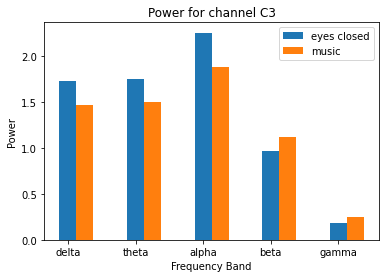

[1.788619365443331, 1.915146321956124, 3.370085979556899, 1.161628742813031, 0.208729153374612]
[1.772225762775295, 1.9115293900367751, 2.677926886208256, 1.225747641007499, 0.24336309902285103]


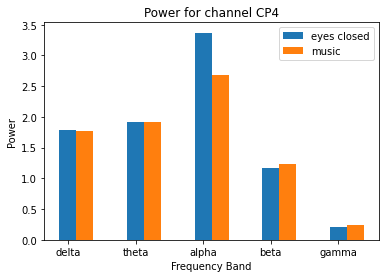

[2.661011640344724, 2.774972988835707, 3.8898869781953813, 1.5841217766367621, 0.297631257465303]
[2.3223302047857333, 2.451096898465795, 3.176491962139265, 1.5180792597981991, 0.312115557259497]


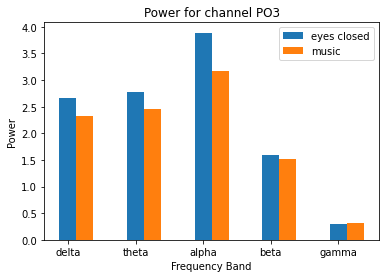

[2.191289912791353, 2.334850837881099, 4.570265356703982, 1.319195226279432, 0.240114773721592]
[1.974751559055984, 2.104459690606194, 3.6293929343616798, 1.30664165524878, 0.258072348999317]


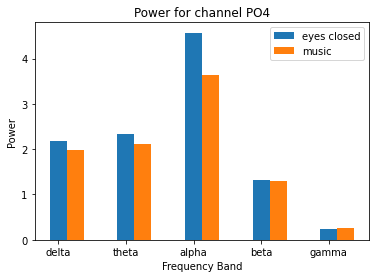

In [8]:
plot_powerdiff_by_channel()

In [9]:
# reduced alpha & increased gamma compared to eyes closed when music was introduced.

In [10]:
# plot power diff by band
def plot_powerdiff_by_band():
    channels = ["C3", "CP4", "PO3", "PO4"]
    groups = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    for band in groups:
        eyesclosed_power = [powerByBand_rolling_eyesclosed[f"{channel}_{band}"] for channel in channels]
        eyesclosed_music_power = [powerByBand_rolling_music[f"{channel}_{band}"] for channel in channels]

        barWidth = 0.25

        # Set position of bar on X axis
        br1 = np.arange(len(channels))
        br2 = [x + barWidth for x in br1]
        # Y - power
        plt.bar(channels, eyesclosed_power, width = barWidth, label='eyes closed')
        plt.bar(br2, eyesclosed_music_power, width = barWidth, label='music')

        print(eyesclosed_power)
        print(eyesclosed_music_power)

        plt.xlabel('Channel')
        plt.ylabel('Power')
        plt.legend()
        plt.title(f'Power for band {band}')
        plt.show()
        plt.close()

[1.730885041193352, 1.788619365443331, 2.661011640344724, 2.191289912791353]
[1.4667911647806031, 1.772225762775295, 2.3223302047857333, 1.974751559055984]


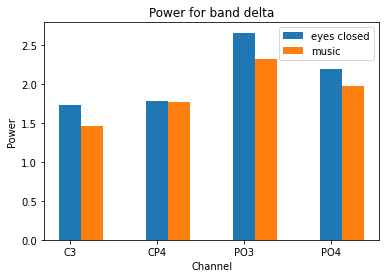

[1.757932640116713, 1.915146321956124, 2.774972988835707, 2.334850837881099]
[1.501871446768306, 1.9115293900367751, 2.451096898465795, 2.104459690606194]


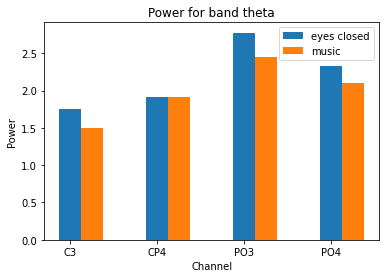

[2.256969788932455, 3.370085979556899, 3.8898869781953813, 4.570265356703982]
[1.882588913158188, 2.677926886208256, 3.176491962139265, 3.6293929343616798]


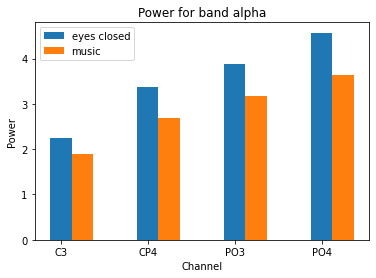

[0.97012851773798, 1.161628742813031, 1.5841217766367621, 1.319195226279432]
[1.115385641664427, 1.225747641007499, 1.5180792597981991, 1.30664165524878]


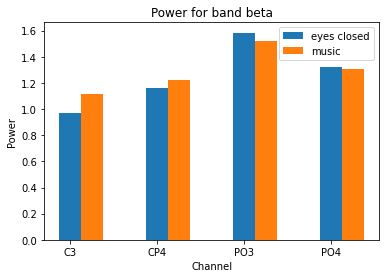

[0.18454441675930103, 0.208729153374612, 0.297631257465303, 0.240114773721592]
[0.24762488412788702, 0.24336309902285103, 0.312115557259497, 0.258072348999317]


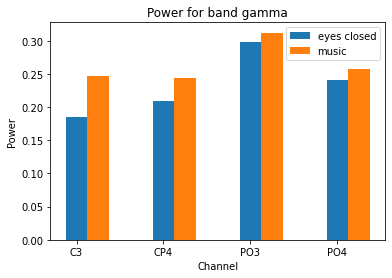

In [11]:
plot_powerdiff_by_band()

In [70]:
powerByBand_rolling_music

unixTimestamp    1.682194e+09
C3_alpha         1.882589e+00
C3_beta          1.115386e+00
C3_delta         1.466791e+00
C3_gamma         2.476249e-01
C3_theta         1.501871e+00
PO3_alpha        3.176492e+00
PO3_beta         1.518079e+00
PO3_delta        2.322330e+00
PO3_gamma        3.121156e-01
PO3_theta        2.451097e+00
PO4_alpha        3.629393e+00
PO4_beta         1.306642e+00
PO4_delta        1.974752e+00
PO4_gamma        2.580723e-01
PO4_theta        2.104460e+00
CP4_alpha        2.677927e+00
CP4_beta         1.225748e+00
CP4_delta        1.772226e+00
CP4_gamma        2.433631e-01
CP4_theta        1.911529e+00
dtype: float64

In [58]:
# alpha


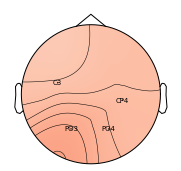

(<matplotlib.image.AxesImage at 0x17fe58130>,
 <matplotlib.contour.QuadContourSet at 0x17fe58490>)

In [88]:
# plot top map

import numpy as np
import matplotlib.pyplot as plt
import mne

power_dict = {
    'C3': powerByBand_rolling_music['C3_beta'],
    'PO3': powerByBand_rolling_music['PO3_beta'],
    'PO4': powerByBand_rolling_music['PO4_beta'],
    'CP4': powerByBand_rolling_music['CP4_beta'],
}

# Define the channel names for the 10-10 EEG system
ch_names = list(power_dict.keys())
powers = np.array(list(power_dict.values()))

# Create an info object for the 10-10 EEG system
info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types='eeg', verbose=True)
# Create the montage
montage = mne.channels.make_standard_montage('standard_1005')
info.set_montage(montage)

# Plot the topomap
mne.viz.plot_topomap(powers, info, ch_type='eeg', vlim=(0,5), names=power_dict.keys(), size=3, show=True)